<a href="https://colab.research.google.com/github/hoihui/tutorial/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install -U torch torchvision
import torch
cuda=torch.cuda.is_available()
torch.__version__, cuda

('1.1.0', False)

In [1]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

# MNIST w/ torch

https://github.com/udacity/deep-learning-v2-pytorch/tree/master/autoencoder

In [4]:
import torch

num_workers = 0  # number of subprocesses to use for data loading
batch_size = 20  # how many samples per batch to load
imgsize = 28
epochs = 20
patience = 2  #early stopping

## Load Data

In [7]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
    
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

print(len(train_data))

60000


In [ ]:
#visualize
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(15, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

## Linear Autoencoder

Inputs=outputs=28x28 length vectors. The encoder and decoder will be made of two linear layers, each. The depth dimensions should change as follows: 784 inputs > encoding_dim > 784 outputs. All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,encoding_dim):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(28*28, encoding_dim)
        self.fc2 = nn.Linear(encoding_dim, 28*28)        

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = Autoencoder(encoding_dim=32)
print(model)

criterion = nn.MSELoss()  # Prob output with MSELoss
optimizer = torch.optim.Adam(model.parameters())

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


In [15]:
images, labels = next(iter(train_loader))
print(images.shape)
print(model(images).shape)

torch.Size([20, 1, 28, 28])
torch.Size([20, 784])


### Train

In [ ]:
if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = 0.
    
    for data, _ in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        data = data.view(data.size(0), -1)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)        # autoencoder: target=input
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

### Evaluate

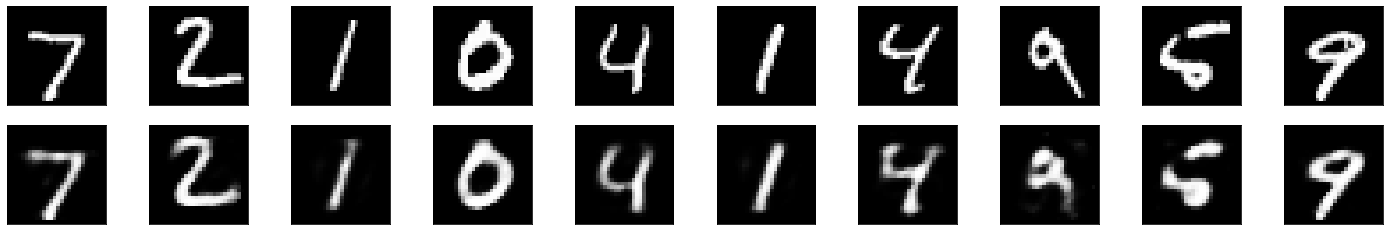

In [21]:
images, _ = next(iter(test_loader))
output = model(images.view(images.size(0), -1)).view(batch_size, 1, 28, 28)
output = output.detach()# detach output from requires_grad so that it can be converted to numpy

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Convolutional Autoencoder

* encoder: typical CNN with maxpooling
* decoder: needs to upsample:
 * uses **transposed convolutional layers** `nn.ConvTranspose2d`. Avoid checkerboard patterns by setting `stride=kernel_size`, or
 * use `F.interpolate` and normal `Conv2d` to increase width and height

In [35]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder ##
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # depth grows 1 -> 16
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)  # depth shrinks 16 -> 4
        self.pool = nn.MaxPool2d(2, 2)
        
        ## for decoder choice 1 ##
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2) # depth grows 4 -> 16, kernelsize=stride
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2) # depth shrinks 16 -> 1                
        ## for decoder choice 2 ##
        self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        ## encode/inference ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)             # size halved
        x = F.relu(self.conv2(x))
        x = self.pool(x)             # size halved
        
        ## decode/generation choice 1 ##
#         x = F.relu(self.t_conv1(x))     # size doubled 
#         x = F.sigmoid(self.t_conv2(x))  # size doubled 
        
        ## decode/generation choice 2 ##
        x = F.interpolate(x, scale_factor=2, mode='nearest') # size doubled 
        x = F.relu(self.conv4(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest') # size doubled 
        x = F.sigmoid(self.conv5(x))
                
        return x

model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

In [ ]:
if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = 0.
    
    for data, _ in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)        # autoencoder: target=input
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

### Evaluate

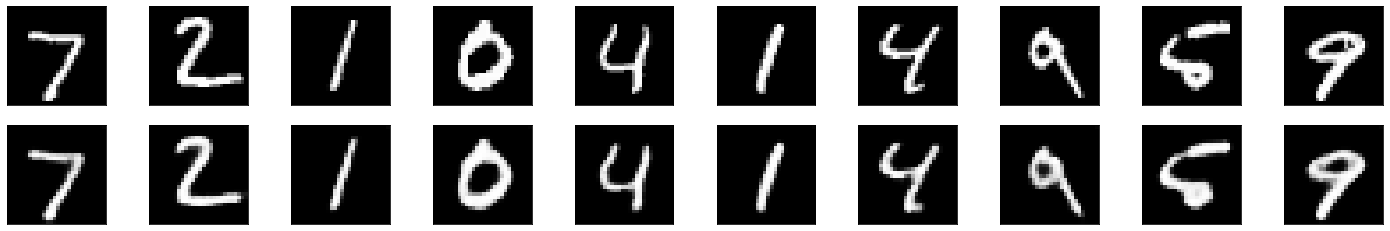

In [39]:
images, _ = next(iter(test_loader))
output = model(images)
output = output.detach()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Denoising Convolutional Autoencoder

use noisy images as input and the original, clean images as targets.

use deeper convolutional layers here; layers with more feature maps

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)# one conv layer to decrease the depth


    def forward(self, x):
        ## encode ##
        x = self.pool(F.relu(self.conv1(x)))# size halved
        x = self.pool(F.relu(self.conv2(x)))# size halved
        x = self.pool(F.relu(self.conv3(x)))# size halved
        
        ## decode ##
        x = F.relu(self.t_conv1(x))  # size doubled
        x = F.relu(self.t_conv2(x))  # size doubled
        x = F.relu(self.t_conv3(x))  # size doubled
        x = F.sigmoid(self.conv_out(x))
                
        return x

model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [41]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

In [45]:
noise = 0.5 # noisy scale

In [ ]:
if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = 0.
    
    for data, _ in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        noisy_imgs = data + noise * torch.randn(*data.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)

        optimizer.zero_grad()
        output = model(noisy_imgs)
        loss = criterion(output, data)        # autoencoder: target=input
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

### Evaluate

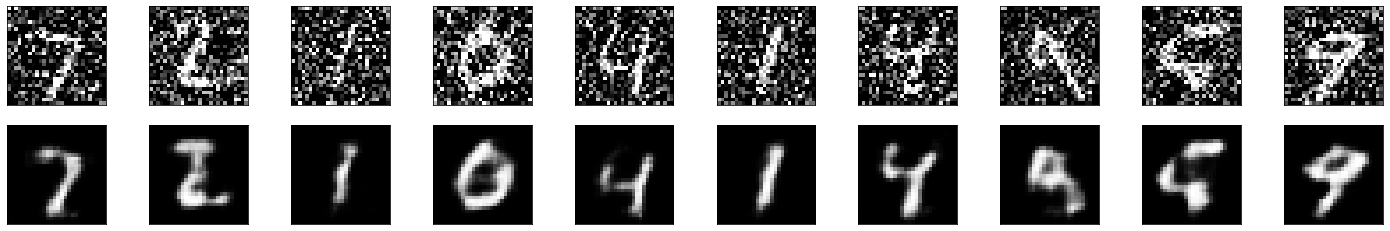

In [48]:
images, _ = next(iter(test_loader))
noisy_imgs = images + noise * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

output = model(noisy_imgs)
output = output.detach()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# MNIST Conv VAE w/ tensorflow

https://www.tensorflow.org/alpha/tutorials/generative/cvae